In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split



In [13]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog

# Functions to be used

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True,training=False):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # Training images are png in 0,1 range, change to 0-255
        if(training==True):
            image=image*255
            image = image.astype(np.uint8) 
        
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

    
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


In [3]:
# Load car and notcar images 
images = glob.glob('*.jpeg')
carimagefiles = glob.glob('Trainingdata/vehicles/*/*.png')
notcarimagefiles = glob.glob('Trainingdata/non-vehicles/*/*.png')

cars = []
notcars = []

for imagefile in carimagefiles:
    car_image = mpimg.imread(imagefile)
    cars.append(car_image)
    
for imagefile in notcarimagefiles:
    car_image = mpimg.imread(imagefile)
    notcars.append(car_image)
    


8792
8968


In [5]:
### TODO: Tweak these parameters and see how the results change.
colorspace = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # 0 # Can be 0, 1, 2, or "ALL"

t=time.time()
#Export features for the training data
car_features = extract_features(carimagefiles, color_space=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,training=True)
notcar_features = extract_features(notcarimagefiles, color_space=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,training=True)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
print(X.shape)
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()

print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

78.8 Seconds to extract HOG features...
(17760, 8460)
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
6.95 Seconds to train SVC...
Test Accuracy of SVC =  0.9907
My SVC predicts:  [ 1.  0.  0.  0.  0.  0.  1.  0.  1.  1.]
For these 10 labels:  [ 1.  0.  0.  0.  0.  0.  1.  0.  1.  1.]
0.0015 Seconds to predict 10 labels with SVC


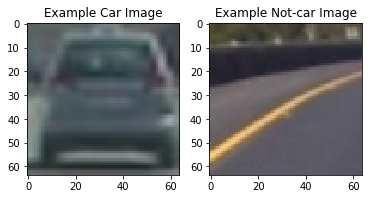

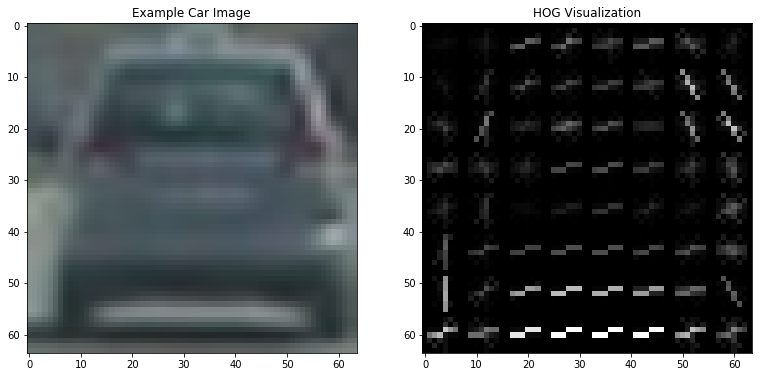

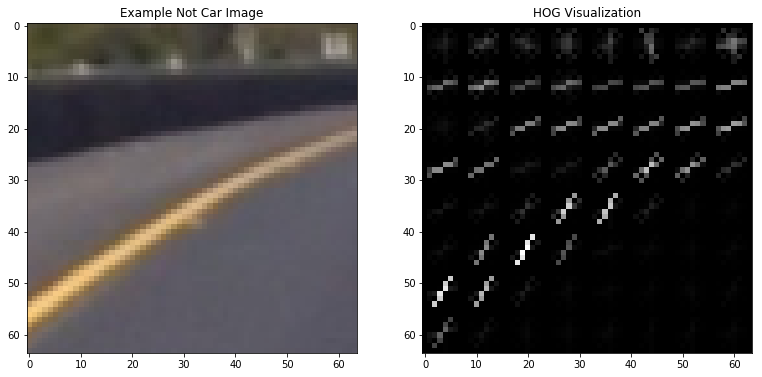

In [6]:
# Plot the examples of can non car and hog features

%matplotlib inline

fig = plt.figure()
plt.subplot(121)
plt.imshow(cars[3])
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcars[6])
plt.title('Example Not-car Image')
#print(cars[3])

gray = cv2.cvtColor(cars[3], cv2.COLOR_RGB2GRAY)
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure(figsize=(13,13))
plt.subplot(121)
plt.imshow(cars[3], cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')


gray = cv2.cvtColor(notcars[6], cv2.COLOR_RGB2GRAY)
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure(figsize=(13,13))
plt.subplot(121)
plt.imshow(notcars[6], cmap='gray')
plt.title('Example Not Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

(720, 1280, 3)
[((48, 400), (144, 496)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((840, 424), (936, 520)), ((864, 400), (960, 496)), ((864, 424), (960, 520)), ((984, 400), (1080, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1056, 424), (1152, 520)), ((1080, 400), (1176, 496)), ((1080, 424), (1176, 520)), ((1104, 424), (1200, 520)), ((1128, 400), (1224, 496)), ((1128, 424), (1224, 520)), ((1128, 448), (1224, 544)), ((1152, 400), (1248, 496)), ((1152, 424), (1248, 520))]


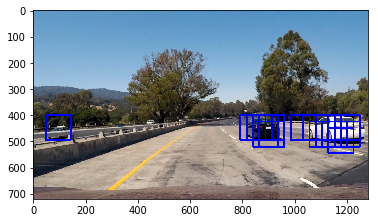

In [19]:
from scipy.ndimage.measurements import label

spatial_size = (32,32) 
hist_bins = 32 



# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    boxlist=[]
    draw_img = np.copy(img)
    # Change image format
    img = img.astype(np.uint8) 
       
        
    img_tosearch = img[ystart:ystop,:,:]

    # This changes colorspace to HLS that was the best performing
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # Then go through image as a sliding window
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
           
            # Combine hog features
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
           
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
             
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                # Compile a list of bounding boxes of detected cars and return it
                boxlist.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return draw_img,boxlist

# Test the function
ystart = 400
ystop = 656
scale = 1.5

img = mpimg.imread('test_images/test1.jpg')
print(img.shape)
out_img,boxlist = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
plt.imshow(out_img)

In [14]:
# Tracking pipeline for the video feed

# False positive threshold
FP_threshold=2
FP_slidingthreshold=20
def tracking_pipeline(img):
    #print(img[0:4,0:4,1:3])
    out_img,boxlist = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    # Add heat to each box in box list
    
    # Read in image similar to one shown above 
    image=img# = mpimg.imread('test_image.jpg')
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    box_list=boxlist
    heat = add_heat(heat,box_list)

    global counter
    global heatlist
    counter=counter+1
    heatlist.append(heat)
    
    if(counter>10):
        heatlist=heatlist[1:]

    # Apply threshold to help remove false positives
    
    # Starting from the second frame, start integrating the heatmaps
    if(counter>1):
        heat_stacked=sum(heatlist)       
        heat_thresholded = apply_threshold(heat_stacked,FP_slidingthreshold)
    
    # The first integrated heatmap is just the first one
    if(counter<2):
        heat_thresholded=heat
        
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat_thresholded, 0, 255)
    #heatmap = np.clip(heat, 0, 255)
   
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

In [15]:
# A modification of the pipeline to output example images to the project report

# False positive threshold
FP_threshold=2
FP_slidingthreshold=15
def tracking_pipeline_record(img):
    #print(img[0:4,0:4,1:3])
    out_img,boxlist = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    # Add heat to each box in box list
    
    # Read in image similar to one shown above 
    image=img# = mpimg.imread('test_image.jpg')
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    box_list=boxlist
    heat = add_heat(heat,box_list)

    global counter
    global heatlist
    global draw_imgs_list
    counter=counter+1
    heatlist.append(heat)
    global heatslist
    
    if(counter>10):
        heatlist=heatlist[1:]

    # Apply threshold to help remove false positives
        
    if(counter>1):
        heat_stacked=sum(heatlist)
        
        heat_thresholded = apply_threshold(heat_stacked,FP_slidingthreshold)
   
    if(counter<2):
        heat_thresholded=heat
        
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat_thresholded, 0, 255)
    #heatmap = np.clip(heat, 0, 255)
    #print(heat_thresholded.shape)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    draw_imgs_list.append(draw_img)
    if(counter>6):
        ilkkaonkiva=kiva
    heatslist=label
    print(label)
    return draw_img

In [16]:
# Pipeline version where 3 differently scaled sliding windows are applied on different parts of the image

# False positive threshold
FP_threshold=2
FP_slidingthreshold=30
def tracking_pipeline_multiple(img):
    
 
    boxlists=[]
    ystart = 350
    ystop = 450
    scale = 1
    out_img,boxlist = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    if(len(boxlist)>0):
        boxlists=(boxlist)
    
    ystart = 400
    ystop = 600
    scale = 1.5
    out_img,boxlist = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    if(len(boxlists)==0):
        if(len(boxlist)>0):
            boxlists=(boxlist)
    else:
        if(len(boxlist)>0):
            boxlists=np.concatenate((boxlists,boxlist),0)
    
    ystart = 400
    ystop = 656
    scale = 1.8
    out_img,boxlist = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
   
    if(len(boxlists)==0):
        if(len(boxlist)>0):
            boxlists=(boxlist)
    else:
        if(len(boxlist)>0):
            boxlists=np.concatenate((boxlists,boxlist),0)
    
    # Read in image similar to one shown above 
    image=img# = mpimg.imread('test_image.jpg')
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    #box_list=boxlist
    box_list=boxlists
    heat = add_heat(heat,box_list)

    global counter
    global heatlist
    counter=counter+1
    heatlist.append(heat)
    
    if(counter>10):
        heatlist=heatlist[1:]

    # Apply threshold to help remove false positives
    
    if(counter>1):
        heat_stacked=sum(heatlist)
      
        heat_thresholded = apply_threshold(heat_stacked,FP_slidingthreshold)
   
    if(counter<2):
        heat_thresholded=heat
        
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat_thresholded, 0, 255)
    #heatmap = np.clip(heat, 0, 255)
 
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

In [17]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
# Run frame by frame to the short test video

counter=0
heatlist=[]
draw_imgs_list=[]
heatslist=[]
project_outputtest = 'test_output.mp4'
clip2test = VideoFileClip('test_video.mp4')
yellow_cliptest = clip2test.fl_image(tracking_pipeline_multiple)
%time yellow_cliptest.write_videofile(project_outputtest, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_outputtest))

In [20]:
# Run frame by frame to the project video

counter=0
heatlist=[]
project_output1 = 'project_output.mp4'
clip2 = VideoFileClip('project_video.mp4')
yellow_clip = clip2.fl_image(tracking_pipeline_multiple)
%time yellow_clip.write_videofile(project_output1, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [19:23<00:00,  1.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

Wall time: 19min 24s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output1))

In [ ]:
# Plot example images to the documentation from integrated heatmaps
counter=0
plt.figure(figsize=(7,14))
for i in range(0,6):
    counter=counter+1
 
    plt.subplot(6,2,counter) 
    #plt.imshow(heatlist[i])
    plt.imshow(heatslist)
    
    counter=counter+1
    plt.subplot(6,2,counter) 
    plt.imshow(draw_imgs_list[i])

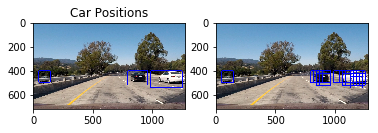

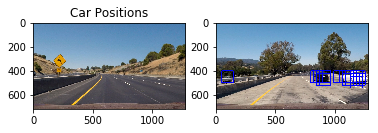

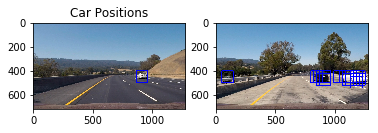

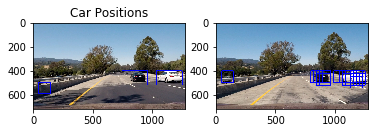

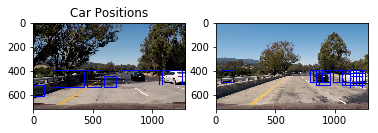

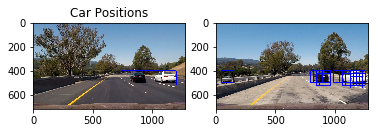

In [23]:
# Plot results on test files
testimagefiles = glob.glob('test_images/*.jpg')
testimages = []

for imagefile in testimagefiles:
    car_image = mpimg.imread(imagefile)  
    testimages.append(car_image)
    
for imagee in testimages:
    counter=0
    heatlist=[]
    ready_img=tracking_pipeline(imagee)

    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(ready_img)
    plt.title('Car Positions')
    plt.subplot(122)

    out_img,boxlist = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    plt.imshow(out_img)
    

In [ ]:
# Run frame by frame to the challenge video, did not work too well, not shown

counter=0
heatlist=[]
challenge_output = 'challenge_output.mp4'
clip2 = VideoFileClip('challenge_video.mp4')
yellow_clip = clip2.fl_image(tracking_pipeline)
%time yellow_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [ ]:
# Run frame by frame to the hard challenge video

counter=0
heatlist=[]
harder_challenge_output = 'harder_challenge_output.mp4'
clip2 = VideoFileClip('harder_challenge_video.mp4')
yellow_clip = clip2.fl_image(tracking_pipeline)
%time yellow_clip.write_videofile(harder_challenge_output, audio=False)

In [ ]:
In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(harder_challenge_output))

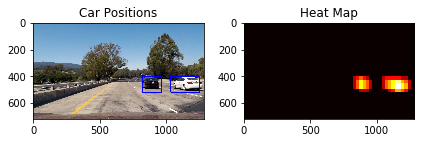

In [24]:
# Plot test data

image=mpimg.imread('test_images/test1.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list

box_list=boxlist
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
